# Notebook in Development

# Segment Anything Model: Tutorial


In this tutorial, we will learn how to use the Segment Anything model for semantic segmentation tasks. We will cover the following steps:

1. Introduction to the Segment Anything model
2. Installing the necessary libraries and dependencies
3. Preparing a Kaggle dataset for segmentation
4. Training the Segment Anything model
5. Using the trained model for prediction
6. Visualizing the results


# Introduction 

The Segment Anything model is a powerful deep learning model for semantic segmentation tasks. It can be fine-tuned to segment objects of interest in images based on a given set of prompts. The model is built using the Vision Transformer (ViT) architecture and can be adapted to various segmentation tasks with minimal training data.


![SAM Image](https://github.com/facebookresearch/segment-anything/blob/main/assets/model_diagram.png?raw=true)

# 2. Installing the necessary libraries and dependencies
Before we begin, let's install the Segment Anything library:

We can also add this model using Kaggle's `Add Model` feature and selecting the `Model Type` from dropdown sections 

In [1]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ojames27
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ojames27
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np

from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

# 3. Preparing a Kaggle dataset for segmentation
In this tutorial, we will use a Kaggle dataset for segmentation. The dataset consists of images and their corresponding segmentation masks. To prepare the data, we need to create a custom dataset class and apply necessary data augmentations and preprocessing.

First, let's import the required libraries and create the custom dataset class, as well as the necessary data augmentation and preprocessing functions:

In [3]:
class SportsClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*', '*.jpg')))

        # Print the number of loaded images
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


Next, instantiate the dataset and data loader with the provided dataset paths:

In [4]:
train_root_dir = os.path.join("../input/sports-classification/train/")
valid_root_dir = os.path.join("../input/sports-classification/valid/")

# train_transform = pth_transforms.Compose([
#     pth_transforms.Resize((256, 256)),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

train_transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
])

valid_transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SportsClassificationDataset(root_dir=train_root_dir, transform=train_transform)
valid_dataset = SportsClassificationDataset(root_dir=valid_root_dir, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size= 8, shuffle=True, num_workers = 2)

Number of images: 13492
Number of images: 500


# Initializing SAM model: 

In [13]:
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l" #
device = "cuda" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)


(224, 224, 3)


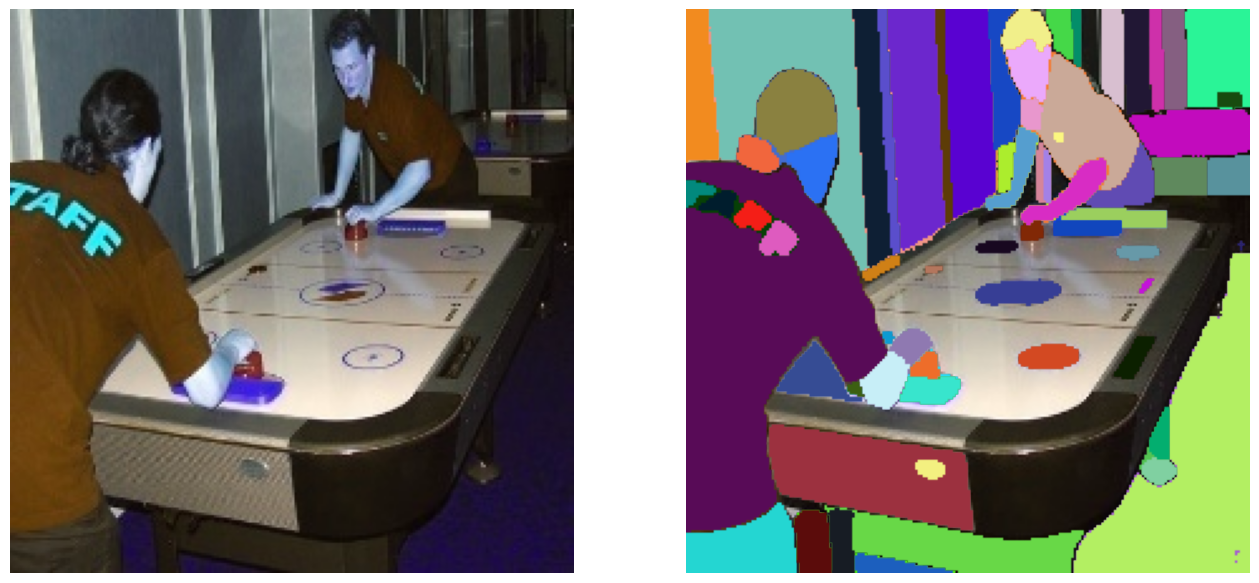

In [28]:
import random

import numpy as np

def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

num_images = 10
random_indices = random.sample(range(len(train_dataset)), num_images)
image_tensor= train_dataset[0]
image_path = "/kaggle/input/sports-classification/test/air hockey/3.jpg"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))
masks = mask_generator1.generate(image)


image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)
# Plot the original image and the mask


# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()
# for idx in random_indices:
#     # Get the image tensor
#     image_tensor= train_dataset[idx]

#     # Apply the mask generator
#     masks = mask_generator1.generate(image_tensor)

#     # Convert the image tensor back to a PIL image
#     image = torchvision.transforms.ToPILImage()(image_tensor)
    
#     # Plot the original image and the mask
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     axs[0].imshow(image)
#     axs[1].imshow(image)
#     show_anns(masks, axs[len(image)][len(image[0])])
#     axs[0].axis('off')
#     axs[1].axis('off')
#     plt.show()
